# Reuters Newswire Classification
*Charles Roberts, Kyle Rohde, Noah Trilling*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

seed = 42
max_sequence_length = 300
vocabulary_size = 2000

2025-04-16 20:18:38.574343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 20:18:38.964244: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 20:18:39.040766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-16 20:18:39.040797: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Exploratory Data Analysis
Load the newswire dataset, word index, and label names.

In [2]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(test_split=0, seed=seed)
index_by_word = reuters.get_word_index(path="reuters_word_index.json")
word_by_offset_index = {index + 3: word for word, index in index_by_word.items()}
label_names = [str(i) for i in range(46)]  # 46 total classes
y_full_label_names_decoded = [label_names[label] for label in y_full]
num_classes = len(label_names)
print(f"Total samples: {len(x_full)}")
print(f"Total classes: {num_classes}")
print(f"Total vocabulary: {len(index_by_word)}")
print(f"Longest Sequence: {max([len(x) for x in x_full])}")
print(f"Shortest Sequence: {min([len(x) for x in x_full])}")
print(f"Average Sequence Length: {np.mean([len(x) for x in x_full])}")
sorted_word_index = sorted(index_by_word.items(), key=lambda x: x[1])
print(f"Top 50 Words: {sorted_word_index[:50]}")
print(f"Bottom 50 Words: {sorted_word_index[-50:]}")
print(f"All Classes: {label_names}")
print(f"Sample x: {x_full[0]}")
print(f"Sample y: {y_full[0]}")
print(f"Sample x (decoded): {[word_by_offset_index.get(i, '?') for i in x_full[0]]}")
print(f"Sample y (decoded): {label_names[y_full[0]]}")

Total samples: 11228
Total classes: 46
Total vocabulary: 30979
Longest Sequence: 2376
Shortest Sequence: 2
Average Sequence Length: 145.96419665122906
Top 50 Words: [('the', 1), ('of', 2), ('to', 3), ('in', 4), ('said', 5), ('and', 6), ('a', 7), ('mln', 8), ('3', 9), ('for', 10), ('vs', 11), ('dlrs', 12), ('it', 13), ('reuter', 14), ('000', 15), ('1', 16), ('pct', 17), ('on', 18), ('from', 19), ('is', 20), ('that', 21), ('its', 22), ('cts', 23), ('by', 24), ('at', 25), ('year', 26), ('be', 27), ('with', 28), ('2', 29), ('will', 30), ('was', 31), ('billion', 32), ('he', 33), ('u', 34), ('s', 35), ('net', 36), ('has', 37), ('would', 38), ('an', 39), ('as', 40), ('5', 41), ('not', 42), ('loss', 43), ('4', 44), ('1986', 45), ('company', 46), ('which', 47), ('but', 48), ('this', 49), ('shr', 50)]
Bottom 50 Words: [('teishoku', 30930), ('bbd', 30931), ('grandmarais', 30932), ('enahnce', 30933), ('jerritt', 30934), ('wilq', 30935), ('cogeca', 30936), ('unflappable', 30937), ('cogeco', 30938),

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


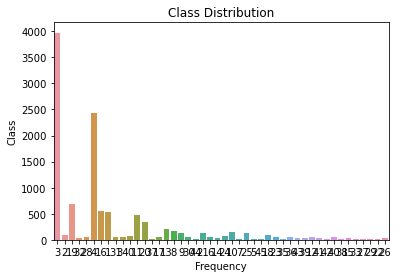

In [3]:
sns.countplot(y_full_label_names_decoded)
plt.title("Class Distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.show()

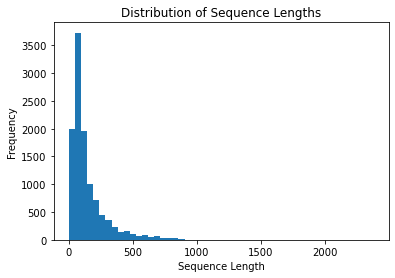

In [4]:
sequence_lengths = [len(seq) for seq in x_full]
plt.hist(sequence_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

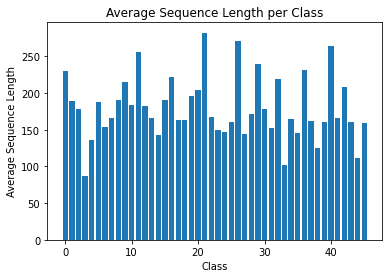

In [5]:
import numpy as np

avg_lengths_per_class = [np.mean([len(x_full[i]) for i in range(len(y_full)) if y_full[i] == label]) for label in range(len(label_names))]
plt.bar(range(len(label_names)), avg_lengths_per_class)
plt.title("Average Sequence Length per Class")
plt.xlabel("Class")
plt.ylabel("Average Sequence Length")
plt.show()

## Data Preprocessing

In [6]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(num_words=vocabulary_size, skip_top=50, maxlen=max_sequence_length, test_split=0, seed=seed)
x_full = [[token for token in sequence if token not in {0, 1, 2}] for sequence in x_full]
x_train, x_temp, y_train, y_temp = train_test_split(
    x_full, y_full, test_size=0.2, random_state=seed
)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=seed
)
x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding="post")
x_val_padded = pad_sequences(x_val, maxlen=max_sequence_length, padding="post")
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding="post")

## Classical Machine Learning

In [7]:
clf = LogisticRegression(max_iter=1000)
clf.fit(x_train_padded, y_train)

y_val_pred = clf.predict(x_val_padded)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

y_test_pred = clf.predict(x_test_padded)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.20      0.33      0.25         3
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00         7
           3       0.57      0.67      0.61       400
           4       0.23      0.34      0.27       189
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        15
          10       0.00      0.00      0.00        22
          11       0.09      0.03      0.05        32
          12       0.00      0.00      0.00         9
          13       0.00      0.00      0.00        15
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          16       0.00      0.00      0.00        48

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-d

## Deep Learning

In [8]:
model = Sequential(
    [
        Embedding(
            input_dim=vocabulary_size, output_dim=64, input_length=max_sequence_length
        ),
        LSTM(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dense(
            num_classes, activation="softmax"
        )
    ]
)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

history = model.fit(
    x_train_padded,
    y_train,
    validation_data=(x_val_padded, y_val),
    epochs=5,
    batch_size=64,
)

2025-04-16 20:19:33.982673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-04-16 20:19:33.983180: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-04-16 20:19:33.983399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-04-16 20:19:33.983633: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2025-04-16 20:19:34.133572: W tensorfl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           128000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 46)                2990      
                                                                 
Total params: 168,174
Trainable params: 168,174
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
125/125 [==============================] - 20s 145ms/step - loss: 2.5752 - accuracy: 0.3721 - val_loss: 2.3596 - val_accuracy: 0.4012
Epoch 2/5
125/125 [===================

In [9]:

test_loss, test_accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

32/32 [==============================] - 1s 34ms/step - loss: 2.3338 - accuracy: 0.3882
Test Accuracy: 0.39


## Transfer Learning (Stretch Goal)

In [13]:
import os
import zipfile
import urllib.request

# Download and extract GloVe embeddings
glove_zip = "glove.6B.zip"
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

if not os.path.exists("glove.6B.100d.txt"):
    if not os.path.exists(glove_zip):
        print("Downloading GloVe embeddings...")
        urllib.request.urlretrieve(glove_url, glove_zip)

    print("Extracting GloVe embeddings...")
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extract("glove.6B.100d.txt")


Extracting GloVe embeddings...


In [ ]:
embeddings_index = {}
embedding_dim = 100
with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = vector

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for word, i in index_by_word.items():
    if i < vocabulary_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



model = Sequential(
    [
        Embedding(
            input_dim=vocabulary_size,  # Vocabulary size (num_words from word_index)
            output_dim=embedding_dim,  # GloVe embedding dimensionality (100)
            weights=[embedding_matrix],  # Use the pre-trained GloVe embeddings
            input_length=x_train_padded.shape[
                1
            ],  # Length of input sequences (padded sequences length)
            trainable=True,  # Freeze the embeddings (set True to allow fine-tuning)
        ),
        LSTM(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dense(num_classes, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

model.summary()

history = model.fit(
    x_train_padded,
    y_train,
    validation_data=(x_val_padded, y_val),
    epochs=5,
    batch_size=64,
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 100)          200000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 46)                2990      
                                                                 
Total params: 249,390
Trainable params: 249,390
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
125/125 [==============================] - 20s 145ms/step - loss: 2.5361 - accuracy: 0.3794 - val_loss: 2.3510 - val_accuracy: 0.4012
Epoch 2/5
125/125 [=================

## Pretrained Model Fine-Tuning (Stretch Goal)